In [2]:
#Importing necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
import wave
import os

# MLP Classifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# LSTM Classifier
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import rmsprop

Using TensorFlow backend.


In [3]:
def extract_mfcc(wav_file_name):
    #This function extracts mfcc features and obtain the mean of each dimension
    #Input : path_to_wav_file
    #Output: mfcc_features'''
    y, sr = librosa.load(wav_file_name)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    
    return mfccs

In [4]:
##### load radvess speech data #####
radvess_speech_labels = [] # to save extracted label/file
ravdess_speech_data = [] # to save extracted features/file
for dirname, _, filenames in os.walk('/content/drive/My Drive/RAVDESS Speech Data'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        radvess_speech_labels.append(int(filename[7:8]) - 1) # the index 7 and 8 of the file name represent the emotion label
        wav_file_name = os.path.join(dirname, filename)
        ravdess_speech_data.append(extract_mfcc(wav_file_name)) # extract MFCC features/file
        
print("Finish Loading the Dataset")

Finish Loading the Dataset


In [5]:
#### convert data and label to array
ravdess_speech_data_array = np.asarray(ravdess_speech_data) # convert the input to an array
ravdess_speech_label_array = np.array(radvess_speech_labels)
ravdess_speech_label_array.shape # get tuple of array dimensions

#### make categorical labels
labels_categorical = to_categorical(ravdess_speech_label_array) # converts a class vector (integers) to binary class matrix
ravdess_speech_data_array.shape
labels_categorical.shape

(2880, 8)

In [12]:
x_train,x_test,y_train,y_test= train_test_split(np.array(ravdess_speech_data_array),labels_categorical, test_size=0.20, random_state=9)

In [13]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [14]:
# Train the model
model.fit(x_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [15]:
# Predict for the test set
y_pred=model.predict(x_test)

In [16]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 56.08%


In [17]:
# Split the training, validating, and testing sets
number_of_samples = ravdess_speech_data_array.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)

In [18]:
# Define the LSTM model
def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(40, 1)))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [19]:
### train using LSTM model
model_A = create_model_LSTM()
history = model_A.fit(np.expand_dims(ravdess_speech_data_array[:training_samples],-1), labels_categorical[:training_samples], validation_data=(np.expand_dims(ravdess_speech_data_array[training_samples:training_samples+validation_samples], -1), labels_categorical[training_samples:training_samples+validation_samples]), epochs=100, shuffle=True)

Train on 2304 samples, validate on 288 samples
Epoch 1/100
2304/2304 [==============================] - 10s 4ms/step - loss: 2.0687 - accuracy: 0.1554 - val_loss: 2.0398 - val_accuracy: 0.1667
Epoch 2/100
2304/2304 [==============================] - 7s 3ms/step - loss: 2.0123 - accuracy: 0.1840 - val_loss: 1.9696 - val_accuracy: 0.1944
Epoch 3/100
2304/2304 [==============================] - 8s 3ms/step - loss: 1.9687 - accuracy: 0.2083 - val_loss: 1.8839 - val_accuracy: 0.2569
Epoch 4/100
2304/2304 [==============================] - 8s 3ms/step - loss: 1.9317 - accuracy: 0.2183 - val_loss: 1.8825 - val_accuracy: 0.2604
Epoch 5/100
2304/2304 [==============================] - 8s 3ms/step - loss: 1.8991 - accuracy: 0.2548 - val_loss: 1.9028 - val_accuracy: 0.2465
Epoch 6/100
2304/2304 [==============================] - 8s 3ms/step - loss: 1.8661 - accuracy: 0.2569 - val_loss: 1.8903 - val_accuracy: 0.2396
Epoch 7/100
2304/2304 [==============================] - 8s 3ms/step - loss: 1.853

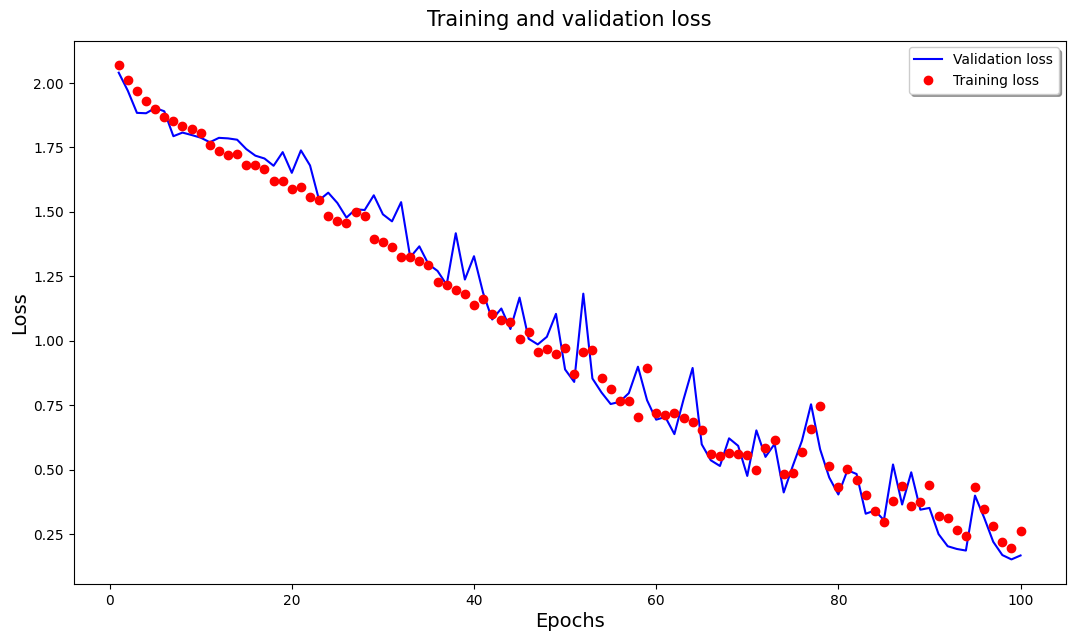

In [20]:
### loss plots using LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
fig_1, ax = plt.subplots(figsize = [12.8, 7.2], dpi = 100)
plt.title('Training and validation loss', fontsize=15, loc='center', pad=10.5)
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.legend(fontsize=10, shadow=True, fancybox=True)
plt.xlabel('Epochs', fontsize=14, labelpad=3)
plt.ylabel('Loss', fontsize=14, labelpad=3)
fig_1.savefig('test_1.png')

<Figure size 432x288 with 0 Axes>

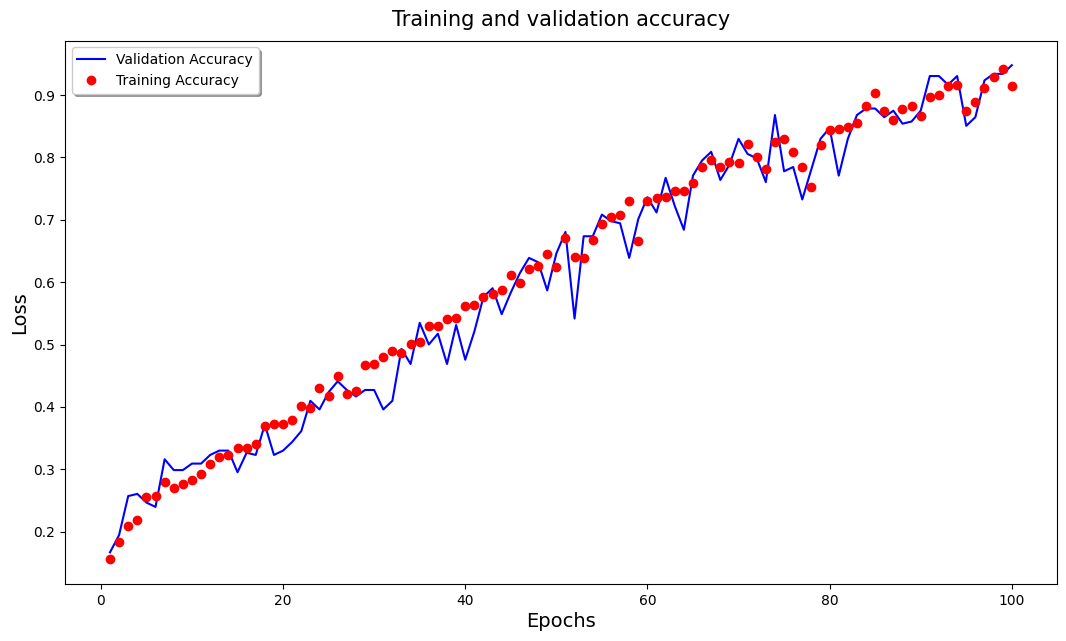

In [21]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig_2, ax = plt.subplots(figsize = [12.8, 7.2], dpi = 100)
plt.title('Training and validation accuracy', fontsize=15, loc='center', pad=10.5)
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.plot(epochs, acc, 'ro', label='Training Accuracy')
plt.legend(fontsize=10, shadow=True, fancybox=True)
plt.xlabel('Epochs', fontsize=14, labelpad=3)
plt.ylabel('Loss', fontsize=14, labelpad=3)
fig_2.savefig('test_2.png')